<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [ ]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

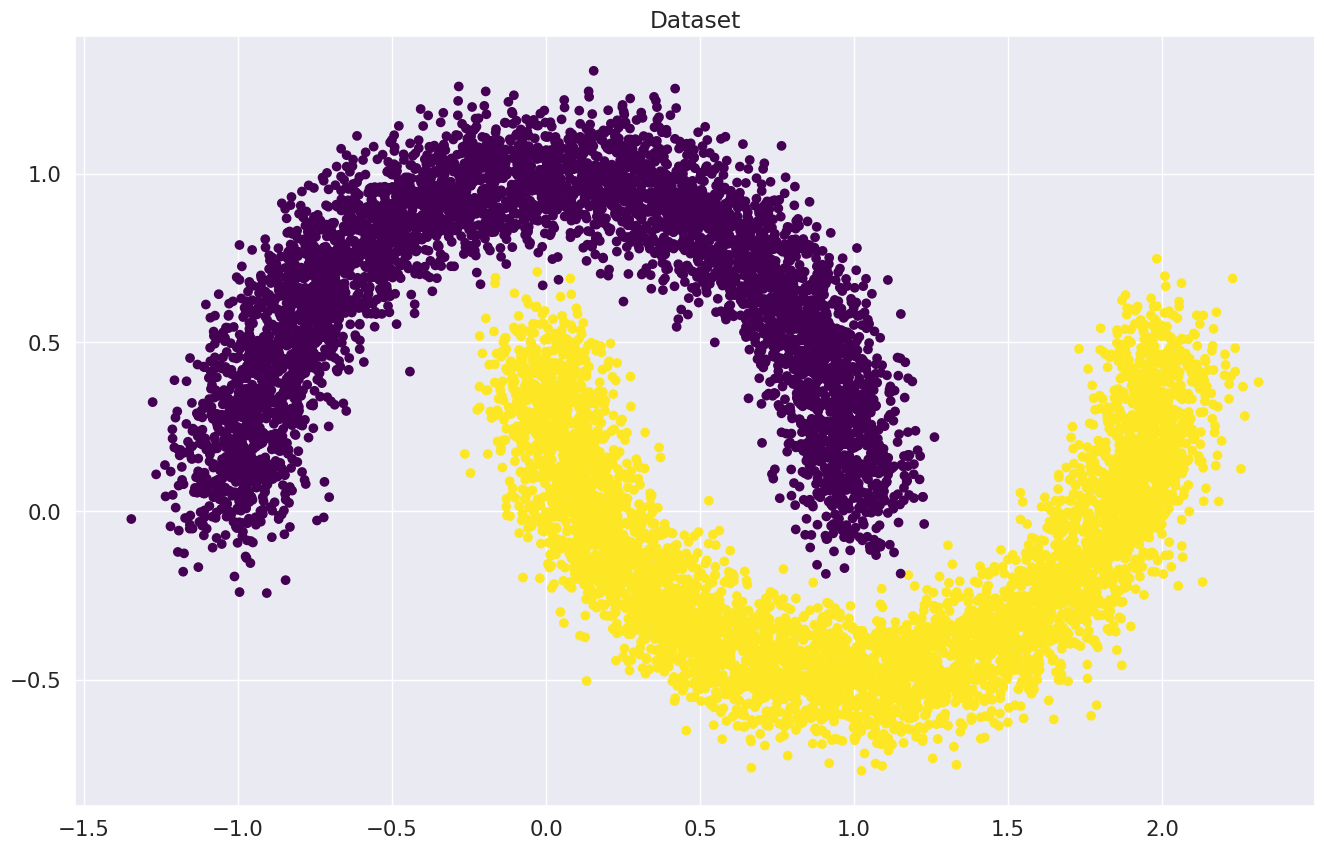

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [ ]:
X_train_t = torch.tensor(data=X_train, dtype=torch.float32) # YOUR CODE GOES HERE
y_train_t = torch.tensor(data=y_train, dtype=torch.float32)# YOUR CODE GOES HERE
X_val_t = torch.tensor(data=X_val, dtype=torch.float32) # YOUR CODE GOES HERE
y_val_t = torch.tensor(data=y_val, dtype=torch.float32) # YOUR CODE GOES HERE

In [ ]:
y_val_t.shape

torch.Size([2500])

Создаем `Dataset` и `DataLoader`.

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features)) # YOUR CODE GOES HERE
        print(self.weights.shape)
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features)) # YOUR CODE GOES HERE

    def forward(self, x):
        x = x @ self.weights # YOUR CODE GOES HERE
        if self.bias:
            x += self.bias_term   # YOUR CODE GOES HERE
        return x

In [ ]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

torch.Size([2, 1])


**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [ ]:
total_params = sum(param.numel() for param in linear_regression.parameters() if param.requires_grad)
print(f'Количество обучаемых параметров у получившейся модели равно: {total_params}')#YOUR CODE

Количество обучаемых параметров у получившейся модели равно: 3


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [ ]:
tol = 1e-3
ans = 0
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch) # YOUR CODE. Use linear_regression to get outputs
        loss = loss_function(outp[:, 0], y_batch) # YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        ans = it + epoch * len(train_dataloader)
        break

Iteration: 0
Batch accuracy: 0.765625
Iteration: 100
Batch accuracy: 0.7890625
Iteration: 200
Batch accuracy: 0.8125
Iteration: 300
Batch accuracy: 0.8984375
Iteration: 400
Batch accuracy: 0.875
Iteration: 500
Batch accuracy: 0.90625

Iteration: 578.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?


In [ ]:
f'Ответ:{ans}'

'Ответ:578'

### Визуализируем результаты

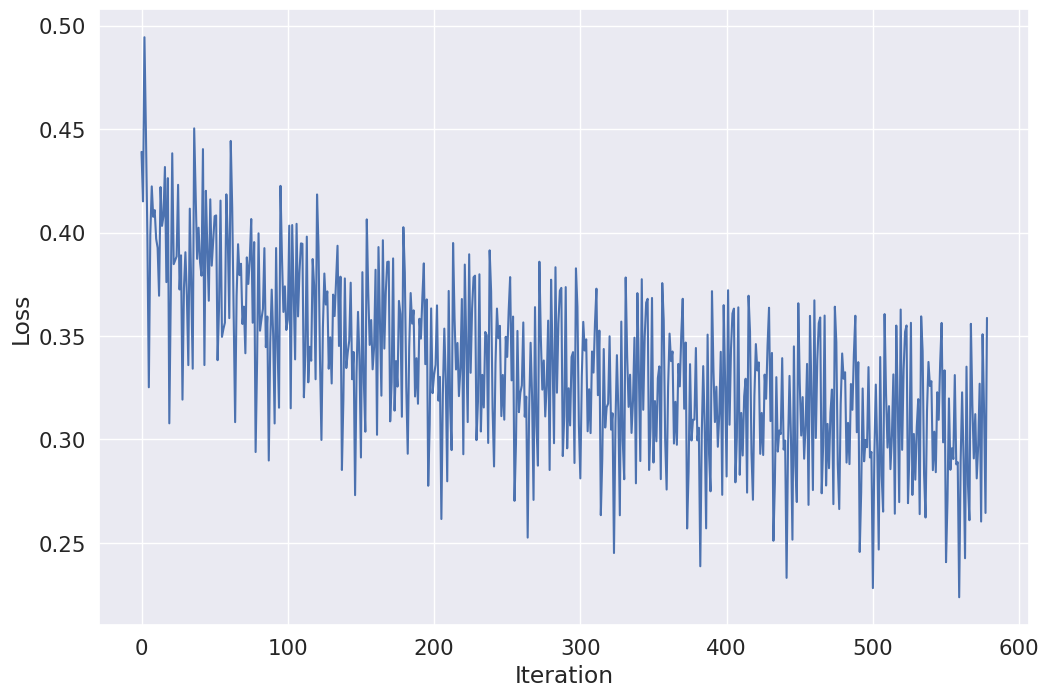

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

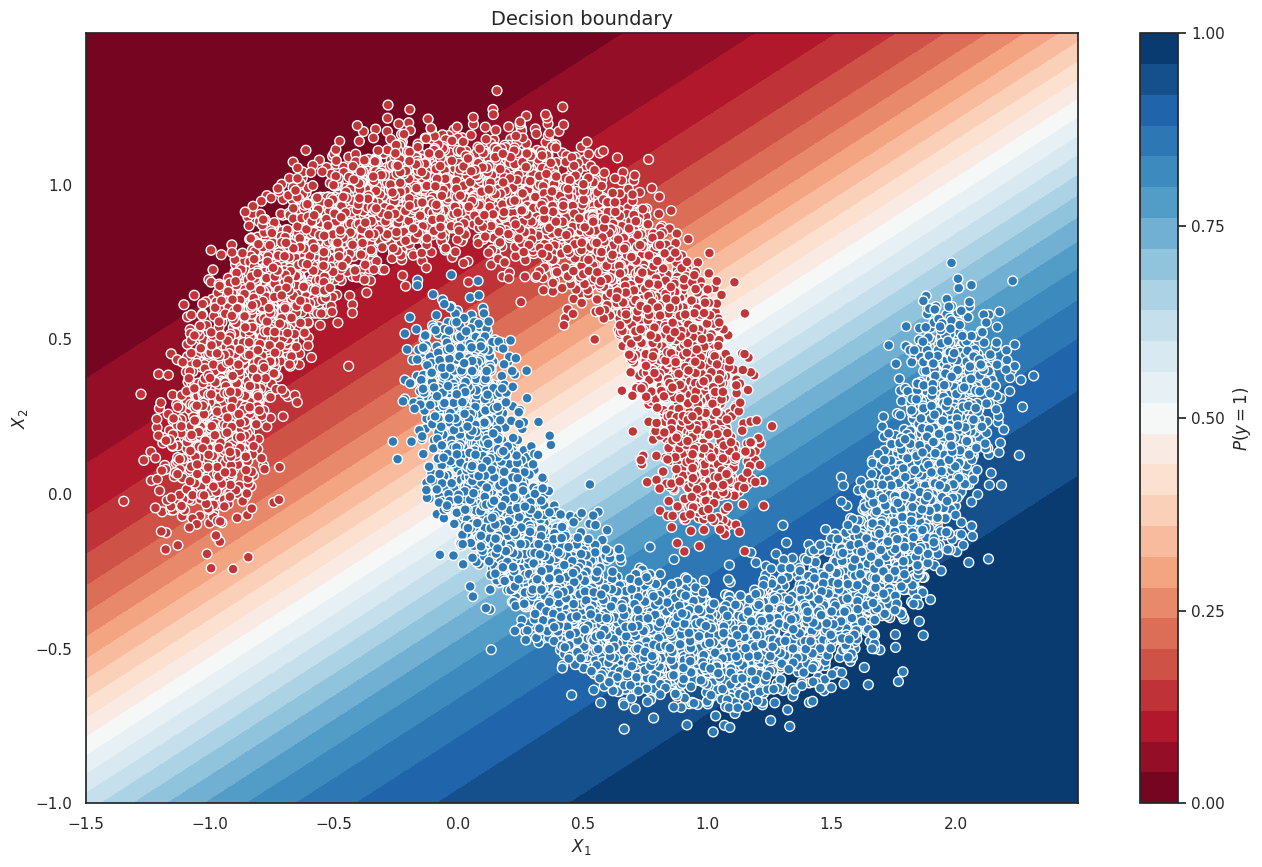

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)  # <YOUR CODE>
        preds = torch.sigmoid(outp) #YOUR CODE. Compute predictions
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [ ]:
from sklearn.metrics import accuracy_score
ans_accuracy = 0
predictions = predict(val_dataloader, linear_regression)
binary_predictions = (predictions > 0.5).astype(int)
ans_accuracy = accuracy_score(y_val_t, binary_predictions)
# YOUR CODE. Compute total accuracy
ans_accuracy

0.8584

**Вопрос 3**

*   Новый пункт
*   Новый пункт



Какое `accuracy` получается после обучения?


In [ ]:
print(f'Ответ: {ans_accuracy}')

Ответ: 0.8584


# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [52]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs
from torch.utils.data import DataLoader

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, drop_last=True) # YOUR CODE GOES HERE
valid_dataloader = DataLoader(val_dataset, drop_last=True) # YOUR CODE GOES HERE

In [53]:
train_dataloader.dataset.train_data.shape

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000, 28, 28])

In [54]:
train_dataloader.dataset.train_data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [55]:
dataiter = iter(train_dataloader)
batch = next(dataiter)
example_data = batch[0]
example_data.size()

torch.Size([1, 1, 28, 28])

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [ ]:
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128, 10),
    #YOUR CODE. Add layers to your sequential class
)

In [ ]:
criterion = nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [56]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}

for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
          # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            if k == "train":
              model.train()
              optimizer.zero_grad()
              outp = model(x_batch)
            else:
              # YOUR CODE. Set model to ``eval`` mode and calculate outputs
              model.eval()
              with torch.no_grad():
                outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum() # YOUR CODE GOES HERE
            all = y_batch.size(0) # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
                # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8916
Loader: valid. Accuracy: 0.9192
Epoch: 2
Loader: train. Accuracy: 0.9276
Loader: valid. Accuracy: 0.9147
Epoch: 3
Loader: train. Accuracy: 0.9374333333333333
Loader: valid. Accuracy: 0.8984
Epoch: 4
Loader: train. Accuracy: 0.9417333333333333
Loader: valid. Accuracy: 0.9252
Epoch: 5
Loader: train. Accuracy: 0.9456333333333333
Loader: valid. Accuracy: 0.9374
Epoch: 6
Loader: train. Accuracy: 0.9475833333333333
Loader: valid. Accuracy: 0.9509
Epoch: 7
Loader: train. Accuracy: 0.9513
Loader: valid. Accuracy: 0.923
Epoch: 8
Loader: train. Accuracy: 0.9527666666666667
Loader: valid. Accuracy: 0.9414
Epoch: 9
Loader: train. Accuracy: 0.9539166666666666
Loader: valid. Accuracy: 0.9558
Epoch: 10
Loader: train. Accuracy: 0.9528
Loader: valid. Accuracy: 0.9384


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [ ]:
elu_accuracy = accuracy["valid"]
# elu_accuracy = [0.8872, 0.869, 0.9026, 0.8924, 0.904, 0.9039, 0.9046, 0.9177, 0.8933, 0.9123]

In [ ]:
from tqdm.auto import trange
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)
#YOUR CODE
def test_activation_function(activation):
    model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(784, 128),
      activation,
      nn.Linear(128, 128),
      activation,
      nn.Linear(128, 10),)
    criterion = nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
    optimizer = torch.optim.Adam(model.parameters())
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in trange(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
            # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
              # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum() # YOUR CODE GOES HERE
                all = y_batch.size(0) # YOUR CODE GOES HERE
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
                # YOUR CODE. Calculate gradients and make a step of your optimizer
            accuracy[k].append(epoch_correct/epoch_all)
            print(epoch_correct/epoch_all)
    return accuracy["valid"]

In [34]:
plain_accuracy = test_activation_function(Identical())
plain_accuracy

  0%|          | 0/10 [00:00<?, ?it/s]

0.8338666666666666
0.7827
0.8641
0.8335
0.87005
0.7974
0.8724166666666666
0.8208
0.87565
0.8117
0.8771166666666667
0.8402
0.87655
0.8221
0.8789833333333333
0.8387
0.8788833333333333
0.8679
0.8807666666666667
0.8403


[0.7827,
 0.8335,
 0.7974,
 0.8208,
 0.8117,
 0.8402,
 0.8221,
 0.8387,
 0.8679,
 0.8403]

In [ ]:
relu_accuracy = test_activation_function(nn.ReLU())#YOUR CODE

  0%|          | 0/10 [00:00<?, ?it/s]

0.88985
0.9062
0.9195833333333333
0.8862
0.9211333333333334
0.8954
0.92325
0.8873
0.9257166666666666
0.8995
0.925
0.9252
0.9256333333333333
0.9077
0.9257
0.9269
0.9295
0.9047
0.9282833333333333
0.8965


In [ ]:
relu_accuracy

[0.9062,
 0.8862,
 0.8954,
 0.8873,
 0.8995,
 0.9252,
 0.9077,
 0.9269,
 0.9047,
 0.8965]

In [ ]:
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU())#YOUR CODE
leaky_relu_accuracy

  0%|          | 0/10 [00:00<?, ?it/s]

0.89225
0.88
0.9204666666666667
0.9076
0.92325
0.8828
0.9258666666666666
0.9199
0.9293
0.8684
0.93095
0.9047
0.9335333333333333
0.916
0.9343166666666667
0.9317
0.9363
0.8933
0.9361
0.9057


[0.88, 0.9076, 0.8828, 0.9199, 0.8684, 0.9047, 0.916, 0.9317, 0.8933, 0.9057]

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

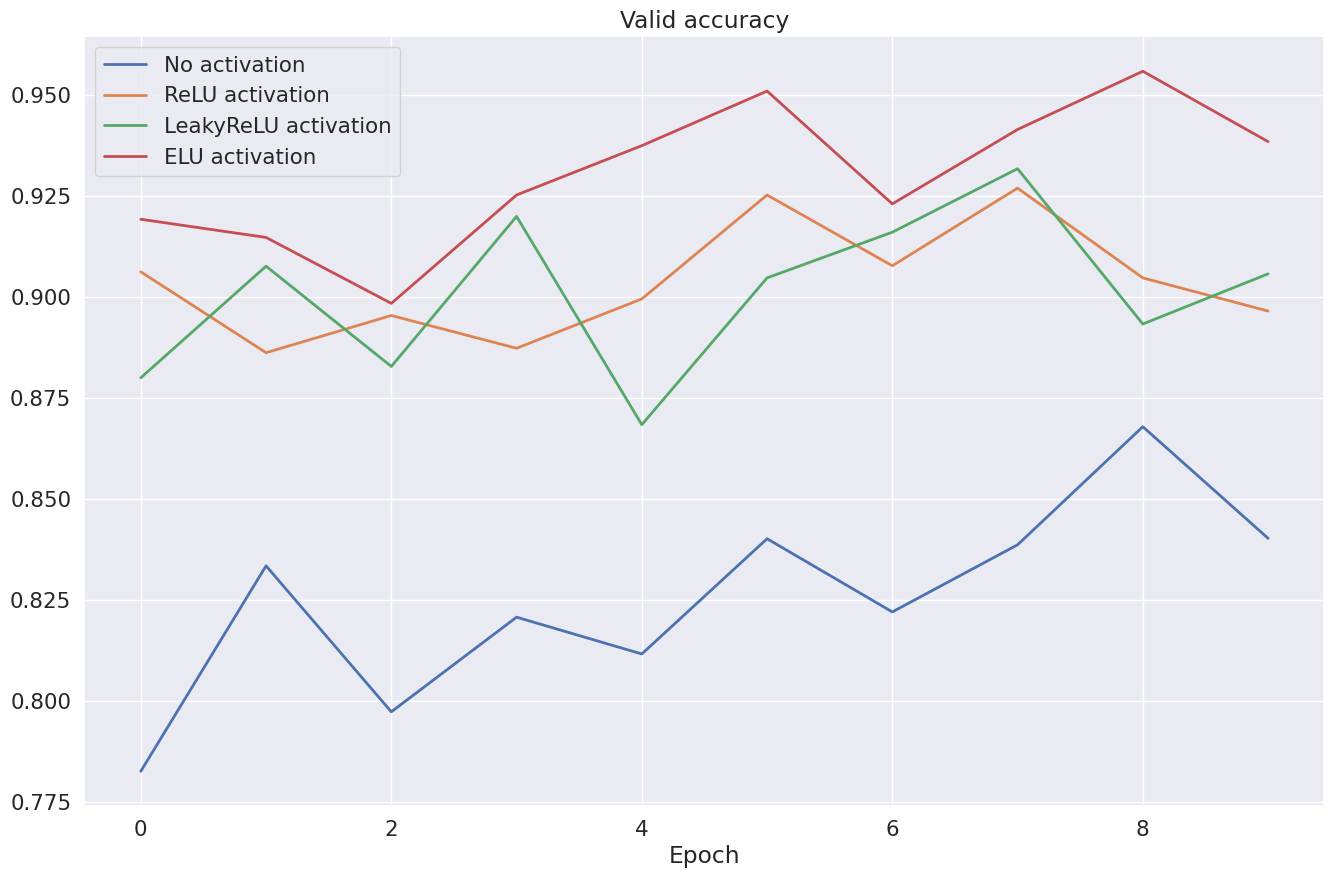

In [35]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

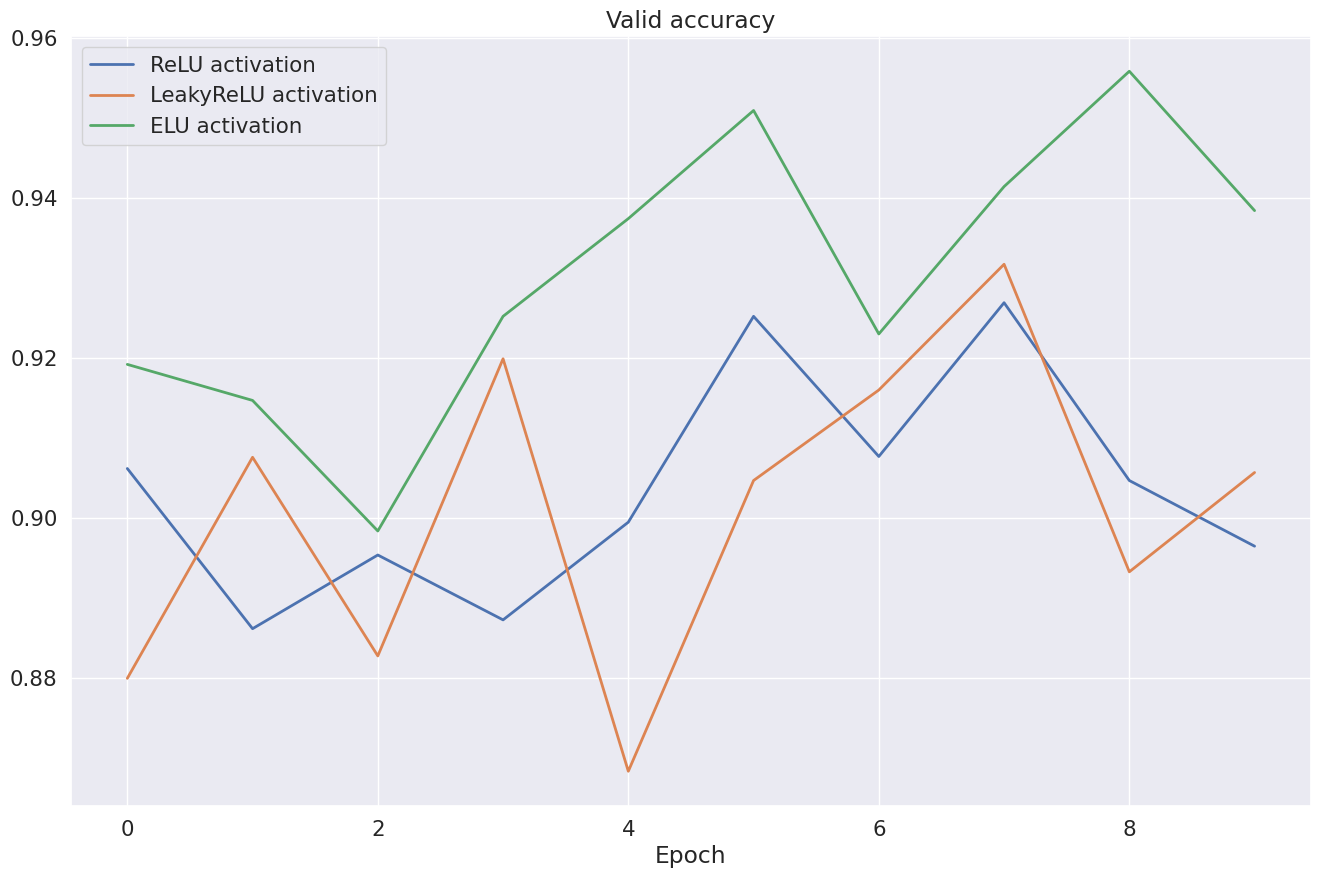

In [36]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** И на Train выборке, и на Test выборке ELU оказалось лучшей.

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [37]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-11-06 18:01:59--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   211KB/s    in 0.2s    

2023-11-06 18:01:59 (211 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



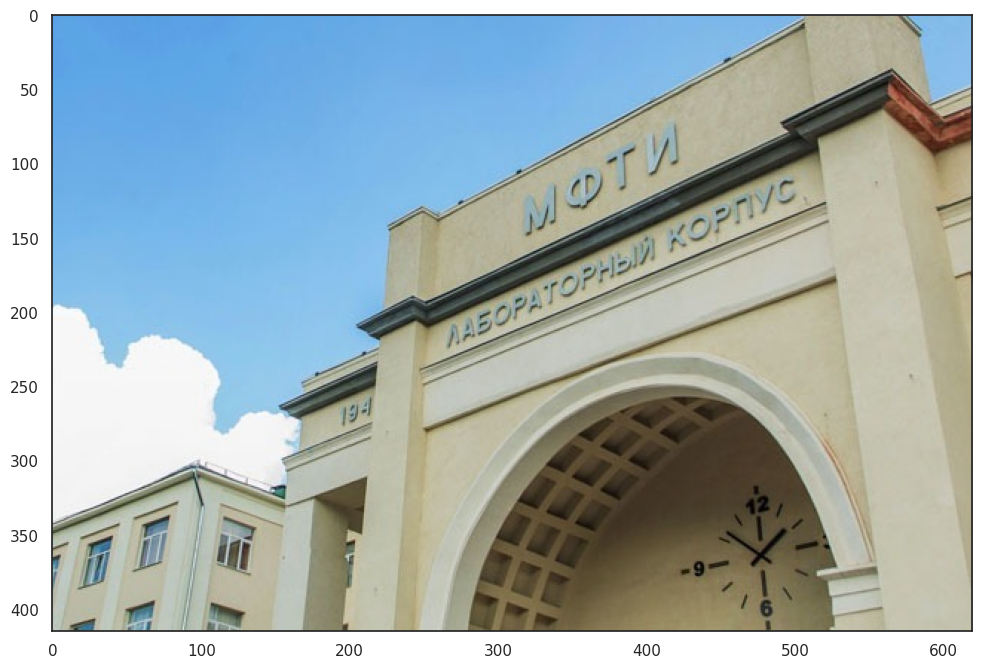

In [38]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [39]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

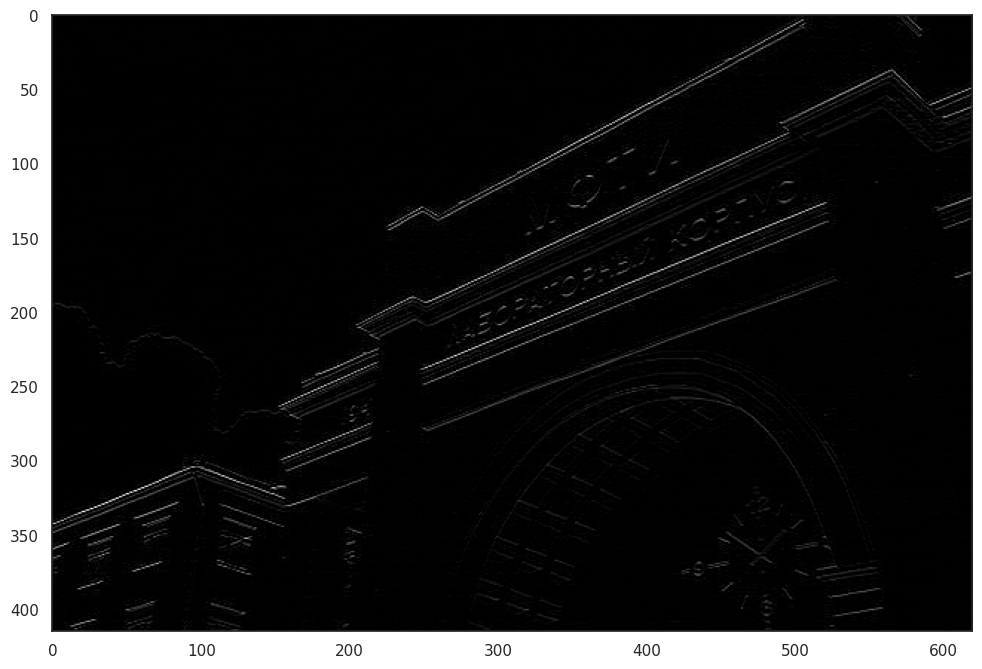

In [40]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** А3 Б5 В4 Г6 Д2 Е1

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [57]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4 * 4 * 16, 120)#YOUR CODE
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)#YOUR CODE
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)#YOUR CODE

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.relu3(x)

        x = self.fc2(x)
        x = self.relu4(x)

        x = self.fc3(x)#YOUR CODE. Apply layers created in __init__.
        return x

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}


### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [69]:
max_epochs = 10
accuracy = {"train": [], "valid": []}

for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
          # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            if k == "train":
              model.train()
              optimizer.zero_grad()
              outp = model(x_batch.cuda())
            else:
              # YOUR CODE. Set model to ``eval`` mode and calculate outputs
              model.eval()
              with torch.no_grad():
                outp = model(x_batch.cuda())
            preds = outp.argmax(-1)
            correct = (preds == y_batch.cuda()).sum() # YOUR CODE GOES HERE
            all = y_batch.size(0) # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch.cuda())
                loss.backward()
                optimizer.step()
                # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.9608833333333333
Loader: valid. Accuracy: 0.9602
Epoch: 2
Loader: train. Accuracy: 0.9746333333333334
Loader: valid. Accuracy: 0.9605
Epoch: 3
Loader: train. Accuracy: 0.97535
Loader: valid. Accuracy: 0.9625
Epoch: 4
Loader: train. Accuracy: 0.9756333333333334
Loader: valid. Accuracy: 0.9602
Epoch: 5
Loader: train. Accuracy: 0.9754166666666667
Loader: valid. Accuracy: 0.9716
Epoch: 6
Loader: train. Accuracy: 0.97625
Loader: valid. Accuracy: 0.9658
Epoch: 7
Loader: train. Accuracy: 0.9745833333333334
Loader: valid. Accuracy: 0.9643
Epoch: 8
Loader: train. Accuracy: 0.97565
Loader: valid. Accuracy: 0.9688
Epoch: 9
Loader: train. Accuracy: 0.97595
Loader: valid. Accuracy: 0.9758
Epoch: 10
Loader: train. Accuracy: 0.974
Loader: valid. Accuracy: 0.9758


In [76]:
lenet_accuracy = accuracy["valid"]
ans = round(lenet_accuracy[-1], 2)

Сравним с предыдущем пунктом

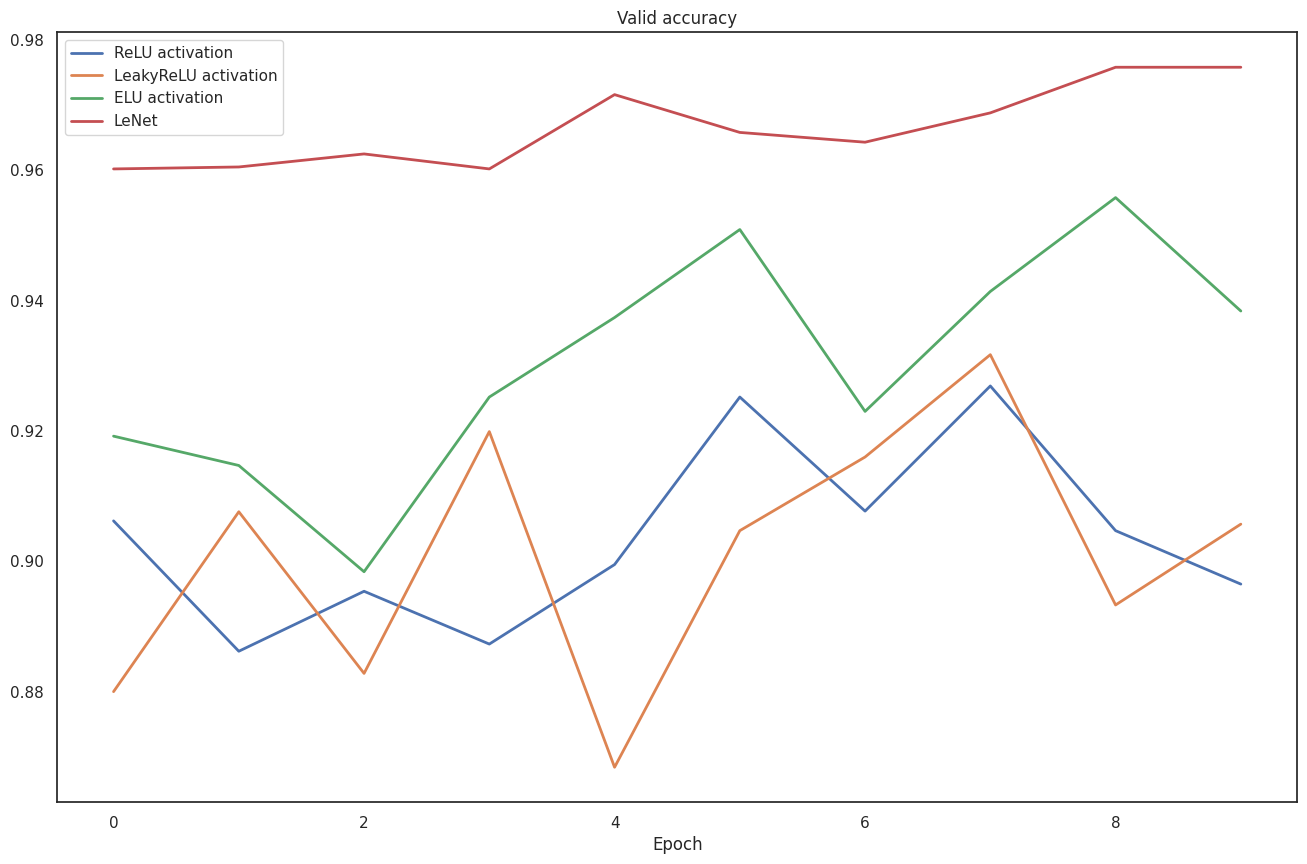

In [74]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?



In [77]:
f"Ответ: {ans}"

'Ответ: 0.98'